# Chronos Autogluon Time Series Forecasting

In [2]:
import numpy as np
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Load dataset as required from Chronos

In [11]:
df = TimeSeriesDataFrame.from_path(
    '/Users/fanisbak/Documents/time_series_forcasting /Thesis_Models/visitors_chronos.csv'
)
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

target
item_id timestamp                  
id1     2023-01-03 09:00:00    41.0
        2023-01-03 10:00:00   115.0
        2023-01-03 11:00:00   165.0
        2023-01-03 12:00:00   163.0
        2023-01-03 13:00:00   117.0

The last step for the data preperation fase is to split the dataset in `training` and `test`. \
We want to predict the visitors of the next week (6 days) so we need the last (7 $days$ x 24 $hours$) = `168 hours` from the dataset. \
We can also use the whole other dataset to train the model.

In [29]:
train_df = df[:-168]
test_df = df[-168:]

# Predicting with Chronos `bolt-small` model

In [20]:
prediction_length = 168
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_df, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/Users/fanisbak/Documents/time_series_forcasting /Thesis_Models/AutogluonModels/ag-20250706_212831'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.0
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:48:46 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.89 GB / 8.00 GB (23.7%)
Disk Space Avail:   20.98 GB / 228.27 GB (9.2%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 168,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 

* Now we can plot the prediction.

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


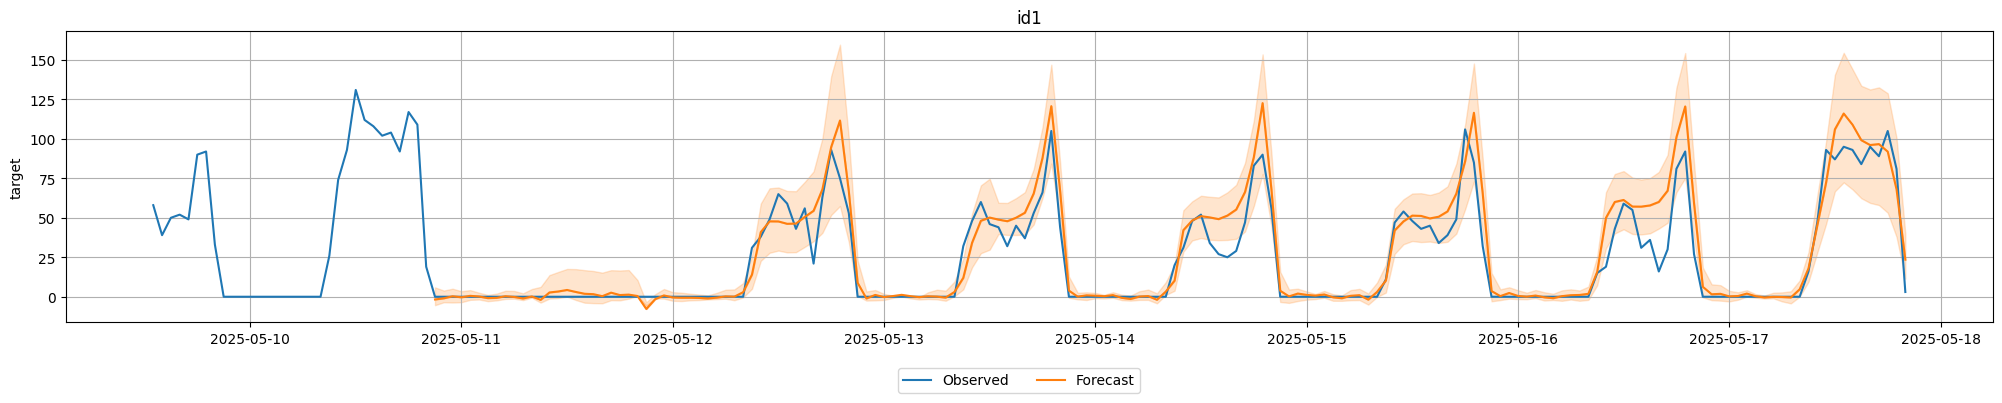

In [21]:
predictions = predictor.predict(train_df)
predictor.plot(
    data=df,
    predictions=predictions,
    item_ids=df.item_ids[:2],
    max_history_length=200,
);

# Evaluation
We use `Mean Absolute Error (MAE)` to evaluate the model.

In [23]:
mae = np.mean(np.abs(predictions['mean'] - test_df['target']))
print(f'Chronos bolt-small finetuned MAE: {mae:.2f}')

Chronos bolt-small finetuned MAE: 7.17


## `Fine tuned model`

We `finetune` the model for better precision and lower `MAE`.

In [30]:
prediction_length = 168

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_df,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/fanisbak/Documents/time_series_forcasting /Thesis_Models/AutogluonModels/ag-20250706_213157'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.0
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:48:46 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       2.19 GB / 8.00 GB (27.4%)
Disk Space Avail:   20.91 GB / 228.27 GB (9.2%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]}

* Now we can plot the prediction.

Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


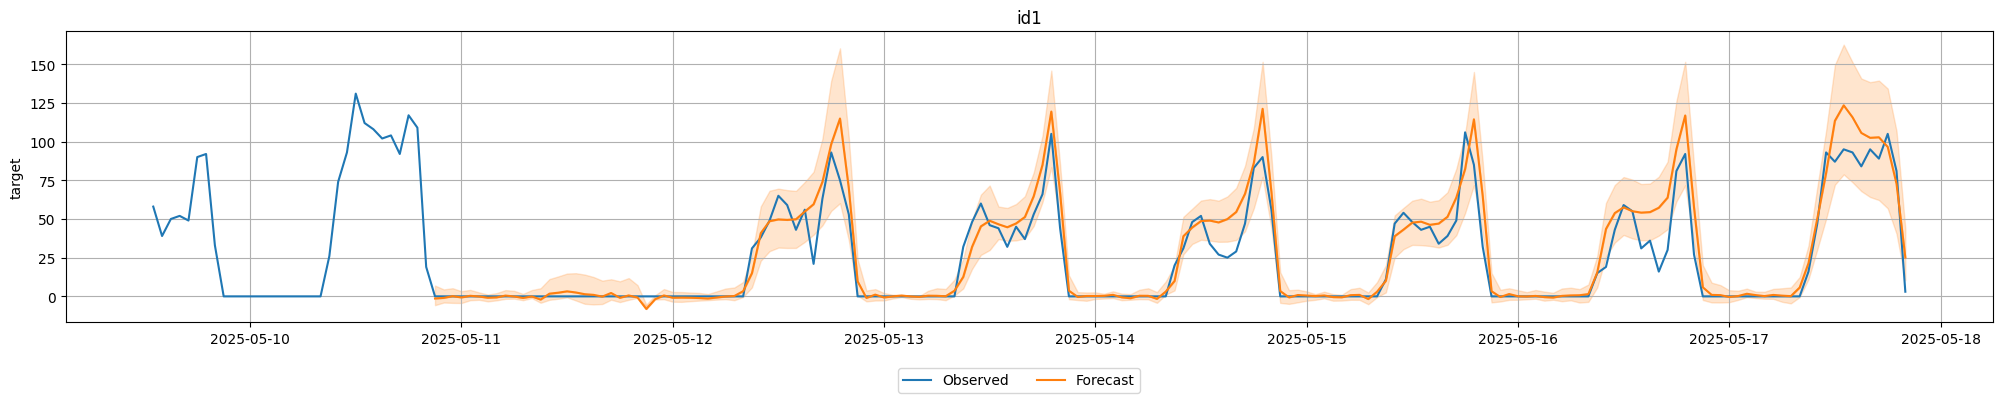

In [36]:
predictions = predictor.predict(train_df)

predictor.plot(
    data=df,
    predictions=predictions,
    item_ids=df.item_ids[:2],
    max_history_length=200,
)

## Evaluation
We use `Mean Absolute Error (MAE)` to evaluate the finetuned model also.

In [28]:
mae = np.mean(np.abs(predictions['mean'] - test_df['target']))
print(f'Chronos bolt-small finetuned MAE: {mae:.2f}')

Chronos bolt-small finetuned MAE: 6.99
